In [ ]:
# default_exp funcs.visualization

In [ ]:
%load_ext autoreload
%autoreload 2

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.point_process import PointProcessUniform

import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
cfg = OmegaConf.load(f'../config/experiment/N2_352_1.yaml')
# cfg.dataloader.bs = 1
# cfg.random_crop.crop_sz = 48
model = load_model_state(cfg, 'model_sl.pkl')
psf, noise, micro = load_psf_micro_psf_noise(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_sl.pkl'))

<All keys matched successfully>

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

In [ ]:
# export
def get_simulation_statistics(decode_dl, micro, min_int=0.2, int_threshold=1, samples = 1):
    
    z_ind = 24
    with torch.no_grad():
        
        for _ in range(samples):
        
            xmax = 0
            while xmax < int_threshold:
                x, local_rate, background = next(iter(decode_dl))
                xmax = x[0,0,z_ind].max()

            x = x[0,0,z_ind].cpu().numpy()
                
            xsim = micro(*PointProcessUniform(local_rate, min_int=min_int).sample())
            xsim_noise = micro.noise(xsim, background).sample()
            
            xsim_noise = xsim_noise.cpu().numpy()[0,0,z_ind]
            background = background[0,0].cpu().numpy()

            fig = plt.figure(figsize=(18,6))
            plt.subplot(131)
            im = plt.imshow(x)
            add_colorbar(im)
            plt.title('Real Image ' + str((x.min())) + ' ' + str((x.max())))

            plt.subplot(132)
            im = plt.imshow(background.mean(0))
            add_colorbar(im)
            plt.title('Background')

            plt.subplot(133)
            im = plt.imshow(xsim_noise)
            add_colorbar(im)
            plt.title('Sim. Image ' + str((xsim_noise.min())) + ' ' + str((xsim_noise.max())))
            
            plt.show()

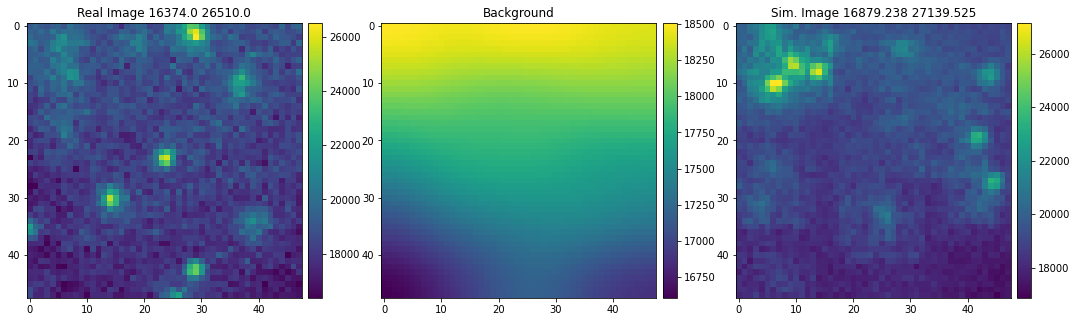

In [ ]:
get_simulation_statistics(decode_dl, micro, samples=1)

In [ ]:
# export
def get_prediction(model, img, micro=None, cuda=True, px_size=np.array([100.,100.,100.]), return_rec=False, threshold=0.1):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        pred_df = model_output_to_df(res_dict, threshold, px_size=px_size)

        if return_rec:
            ae_img_3d = micro(*model_output_to_micro_input(res_dict, threshold=threshold))   
            return pred_df, ae_img_3d + res_dict['background']
            
        return pred_df

def eval_random_crop(decode_dl, model, micro, projection='mean', px_size=np.array([100.,100.,100.]), cuda=False, threshold=0.1, samples=1):
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            x, local_rate, background = next(iter(decode_dl))
            pred_df, rec = get_prediction(model, x[:1], micro=micro, cuda=True, return_rec=True, threshold=threshold)
            pred_df = nm_to_px(pred_df, px_size)

            x = x[0,0].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            axes = plot_3d_projections(x, projection=projection)
            axes[0].scatter(pred_df['x'],pred_df['y'], color='red', s=5.)
            axes[1].scatter(pred_df['x'],pred_df['z'], color='red', s=5.)
            axes[2].scatter(pred_df['y'],pred_df['z'], color='red', s=5.)

            axes[1].set_title('Predictions', size=16)

            axes = plot_3d_projections(rec, projection=projection)

            axes[1].set_title('Reconstruction', size=16)

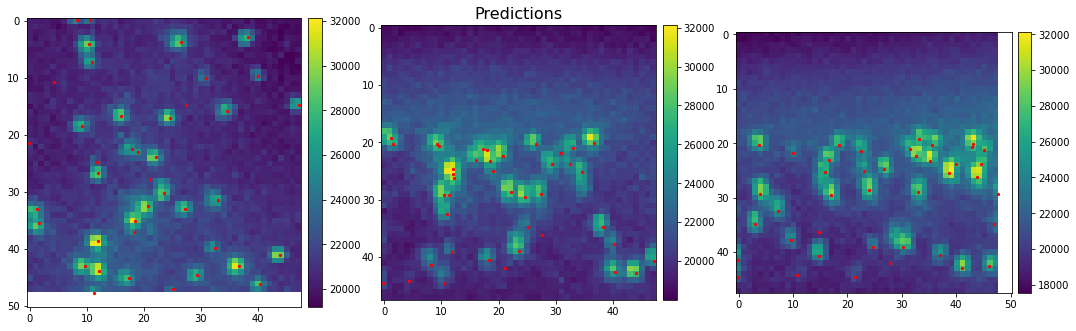

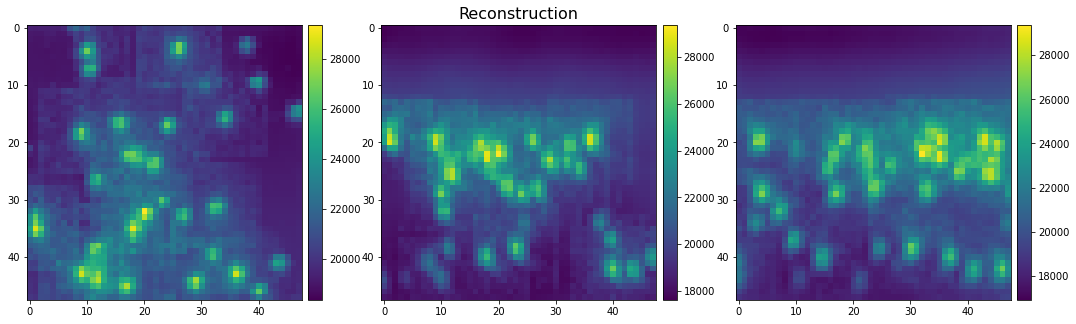

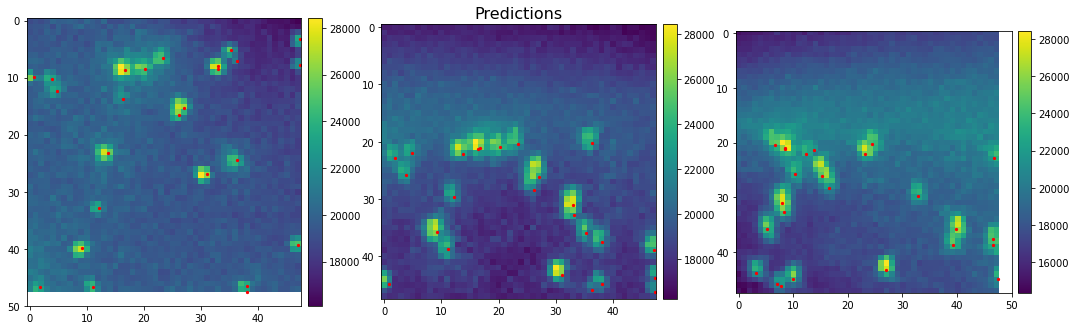

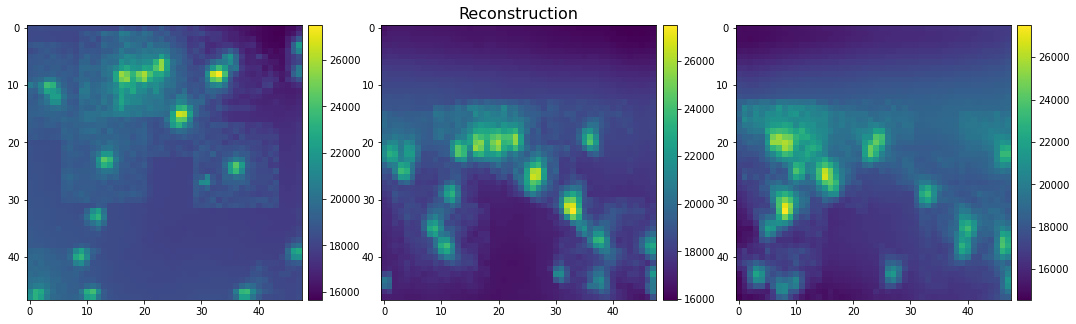

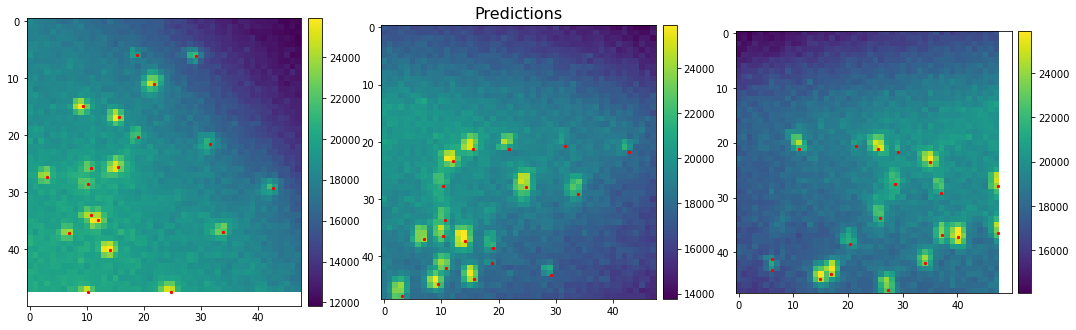

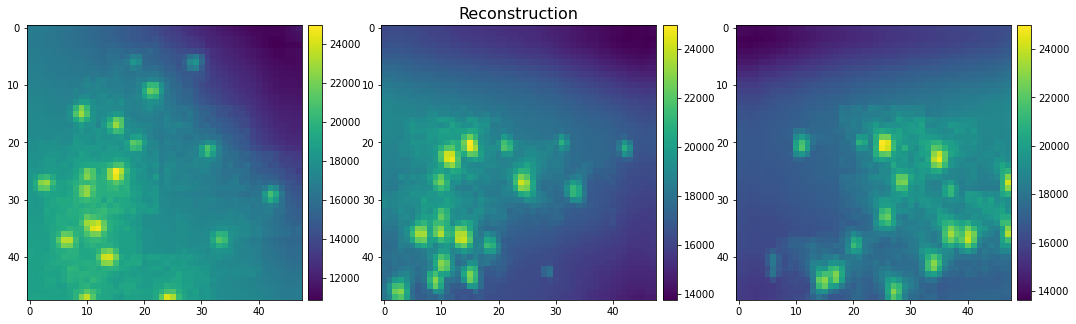

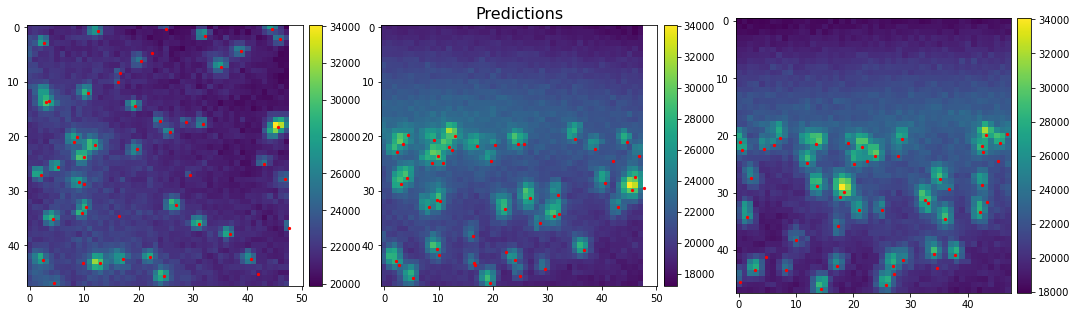

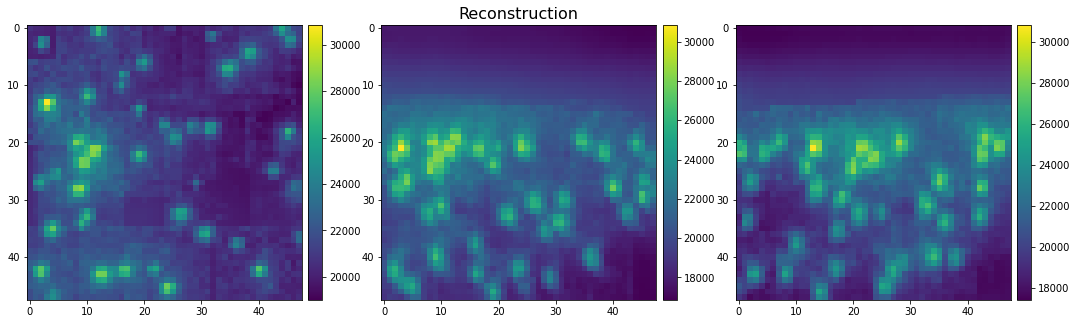

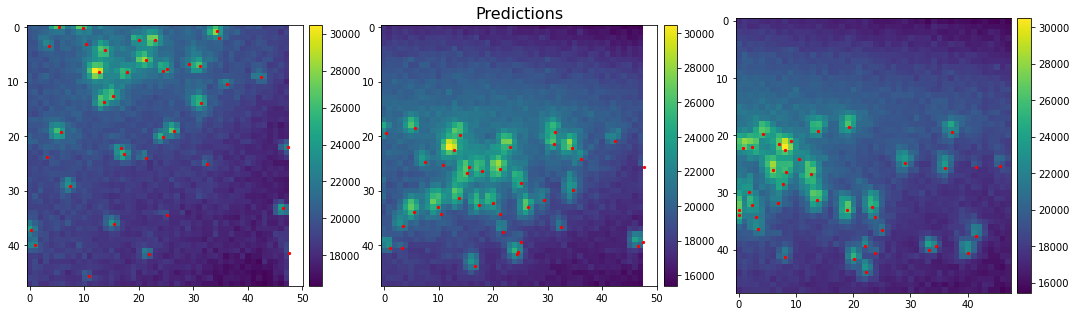

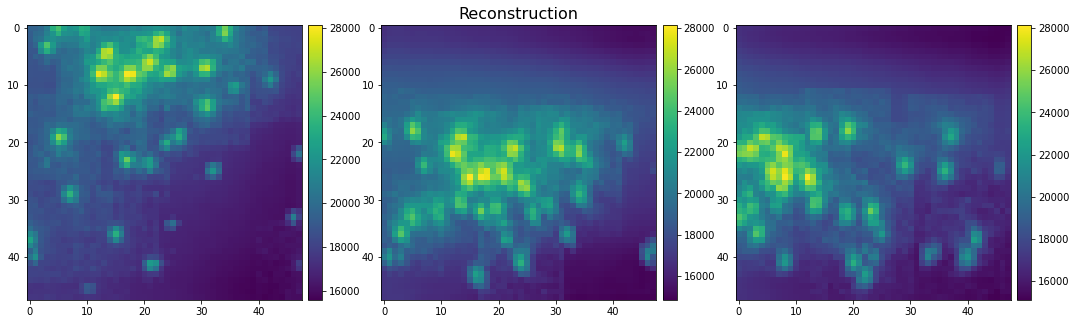

In [ ]:
eval_random_crop(decode_dl, model, micro, projection='max', threshold=0.1, samples=5)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train_sl.ipynb.
Converted 14_train_ae.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted index.ipynb.
